# Lesson 4: Building a Multi-Document Agent


Ref: [deeplearning.ai](https://learn.deeplearning.ai/courses/building-agentic-rag-with-llamaindex/lesson/ix5w5/building-an-agent-reasoning-loop)     
Login with email: ashok@fsm.ac.in (password is the usual one)    
   
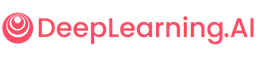

## Setup

In [ ]:
import nest_asyncio
nest_asyncio.apply()

## 1. Setup an agent over 3 papers

**Note**: The pdf files are included with this lesson. To access these papers, go to the `File` menu and select`Open...`.

In [ ]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=hSyW5go0v8",
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "selfrag.pdf",
]

In [ ]:
# 2.0

from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.openai_like import OpenAILike

# 2.1

Settings.llm = OpenAILike(
                          temperature=0.7,
                          model= "gpt-3.5-turbo",  # "gemma-3-27b-it",  #          # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 1000.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )

# 2.2
Settings.embed_model = OllamaEmbedding(
                                        model_name="nomic-embed-text",      # Using foundational model may be overkill
                                        base_url="http://localhost:11434",
                                       )


In [ ]:
from utils import get_doc_tools
from pathlib import Path

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

In [ ]:
initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

In [ ]:
len(initial_tools)

In [ ]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    initial_tools, 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [ ]:
response = agent.query(
    "Tell me about the evaluation dataset used in LongLoRA, "
    "and then tell me about the evaluation results"
)

In [ ]:
response = agent.query("Give me a summary of both Self-RAG and LongLoRA")
print(str(response))

## 2. Setup an agent over 11 papers

### Download 11 ICLR papers

In [ ]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=LzPWWPAdY4",
    "https://openreview.net/pdf?id=VTF8yNQM66",
    "https://openreview.net/pdf?id=hSyW5go0v8",
    "https://openreview.net/pdf?id=9WD9KwssyT",
    "https://openreview.net/pdf?id=yV6fD7LYkF",
    "https://openreview.net/pdf?id=hnrB5YHoYu",
    "https://openreview.net/pdf?id=WbWtOYIzIK",
    "https://openreview.net/pdf?id=c5pwL0Soay",
    "https://openreview.net/pdf?id=TpD2aG1h0D"
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "loftq.pdf",
    "swebench.pdf",
    "selfrag.pdf",
    "zipformer.pdf",
    "values.pdf",
    "finetune_fair_diffusion.pdf",
    "knowledge_card.pdf",
    "metra.pdf",
    "vr_mcl.pdf"
]

To download these papers, below is the needed code:


    #for url, paper in zip(urls, papers):
         #!wget "{url}" -O "{paper}"
    
    
**Note**: The pdf files are included with this lesson. To access these papers, go to the `File` menu and select`Open...`.

In [ ]:
# 5.0
from llama_index.core import SummaryIndex, VectorStoreIndex

# 5.0
summary_index = SummaryIndex(nodes)

# 5.1
vector_index = VectorStoreIndex(
                                 nodes,
                                 show_progres = True
                               )

In [ ]:
# 6.0
summary_query_engine = summary_index.as_query_engine(
                                                     response_mode="tree_summarize",
                                                     use_async=True,  # Optional but gives faster response
                                                    )

# 6.1
vector_query_engine = vector_index.as_query_engine(show_progress = True)

In [ ]:
# 7.0

from llama_index.core.tools import QueryEngineTool

# 7.1
summary_tool = QueryEngineTool.from_defaults(
                                             query_engine=summary_query_engine,
                                             description=(
                                                          "Useful for summarization questions related to MetaGPT"
                                                          ),
                                              )

# 7.2
vector_tool = QueryEngineTool.from_defaults(
                                             query_engine=vector_query_engine,
                                             description=(
                                                           "Useful for retrieving specific context from the MetaGPT paper."
                                                         ),
                                            )


In [ ]:
from utils import get_doc_tools
from pathlib import Path

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

### Extend the Agent with Tool Retrieval

In [ ]:
all_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

In [ ]:
# define an "object" index and retriever over these tools
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

In [ ]:
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

In [ ]:
tools = obj_retriever.retrieve(
    "Tell me about the eval dataset used in MetaGPT and SWE-Bench"
)

In [ ]:
tools[2].metadata

In [ ]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_retriever,
    llm=llm, 
    system_prompt=""" \
You are an agent designed to answer queries over a set of given papers.
Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

""",
    verbose=True
)
agent = AgentRunner(agent_worker)

In [ ]:
response = agent.query(
    "Tell me about the evaluation dataset used "
    "in MetaGPT and compare it against SWE-Bench"
)
print(str(response))

In [ ]:
response = agent.query(
    "Compare and contrast the LoRA papers (LongLoRA, LoftQ). "
    "Analyze the approach in each paper first. "
)